<a href="https://colab.research.google.com/github/LiTaokui/TensorFlow_Toturial/blob/main/Bayesian_Approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow==1.15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 28 kB/s 
     |████████████████████████████████| 50 kB 9.1 MB/s 
     |████████████████████████████████| 3.8 MB 55.0 MB/s 
     |████████████████████████████████| 503 kB 70.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=f984a638b56ba0b100779673145b8ae25a1f6443399dc95393fdd53bd543e5f6
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Iteration 0. Mean squared error: 0.2206.
Iteration 100. Mean squared error: 0.1875.
Iteration 200. Mean squared error: 0.1347.
Iteration 300. Mean squared error: 0.0721.
Iteration 400. Mean squared error: 0.0337.
Iteration 500. Mean squared error: 0.0258.
Iteration 600. Mean squared error: 0.0059.
Iteration 700. Mean squared error: 0.0130.
Iteration 800. Mean squared error: 0.0076.
Iteration 900. Mean squared error: 0.0201.
Iteration 1000. Mean squared error: 0.6868.
Iteration 1100. Mean squared error: 0.0085.
Iteration 1200. Mean squared error: 0.0203.
Iteration 1300. Mean squared error: 0.0372.
Iteration 1400. Mean squared error: 0.0073.
Iteration 1500. Mean squared error: 0.0059.
Iteration 1600. Mean squared error: 0.0125.
Iteration 1700. Mean squared error: 0.0150.
Iteration 1800. Mean squared error: 0.0048.
Iteration 1900. Mean squared error: 0.0081.
Iteration 2000. Mean squared error: 0.0123.
Iteration 2100. Mean squared error: 0.0097.
Iteration 2200. Mean squared error: 0.0122.


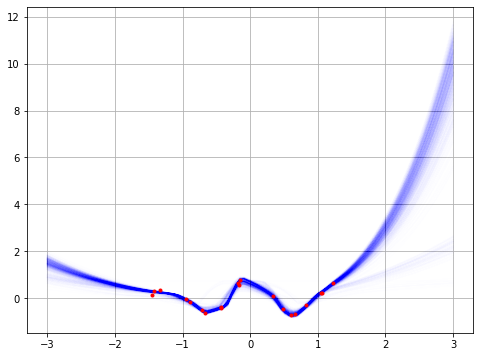

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.distributions import Bernoulli


class VariationalDense:
    """Variational Dense Layer Class"""
    def __init__(self, n_in, n_out, model_prob, model_lam):
        self.model_prob = model_prob
        self.model_lam = model_lam
        self.model_bern = Bernoulli(probs=self.model_prob, dtype=tf.float32)
        self.model_M = tf.Variable(tf.truncated_normal([n_in, n_out], stddev=0.01))
        self.model_m = tf.Variable(tf.zeros([n_out]))
        self.model_W = tf.matmul(
            tf.diag(self.model_bern.sample((n_in, ))), self.model_M
        )

    def __call__(self, X, activation=tf.identity):
        output = activation(tf.matmul(X, self.model_W) + self.model_m)
        if self.model_M.shape[1] == 1:
            output = tf.squeeze(output)
        return output

    @property
    def regularization(self):
        return self.model_lam * (
            self.model_prob * tf.reduce_sum(tf.square(self.model_M)) +
            tf.reduce_sum(tf.square(self.model_m))
        )

# Created sample data.
n_samples = 20
X = np.random.normal(size=(n_samples, 1))
y = np.random.normal(np.cos(5.*X) / (np.abs(X) + 1.), 0.1).ravel()
X_pred = np.atleast_2d(np.linspace(-3., 3., num=100)).T
X = np.hstack((X, X**2, X**3))
X_pred = np.hstack((X_pred, X_pred**2, X_pred**3))

# Create the TensorFlow model.
n_feats = X.shape[1]
n_hidden = 100
model_prob = 0.9
model_lam = 1e-2
model_X = tf.placeholder(tf.float32, [None, n_feats])
model_y = tf.placeholder(tf.float32, [None])
model_L_1 = VariationalDense(n_feats, n_hidden, model_prob, model_lam)
model_L_2 = VariationalDense(n_hidden, n_hidden, model_prob, model_lam)
model_L_3 = VariationalDense(n_hidden, 1, model_prob, model_lam)
model_out_1 = model_L_1(model_X, tf.nn.relu)
model_out_2 = model_L_2(model_out_1, tf.nn.relu)
model_pred = model_L_3(model_out_2)
model_sse = tf.reduce_sum(tf.square(model_y - model_pred))
model_mse = model_sse / n_samples
model_loss = (
    # Negative log-likelihood.
    model_sse +
    # Regularization.
    model_L_1.regularization +
    model_L_2.regularization +
    model_L_3.regularization
) / n_samples
train_step = tf.train.AdamOptimizer(1e-3).minimize(model_loss)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        sess.run(train_step, {model_X: X, model_y: y})
        if i % 100 == 0:
            mse = sess.run(model_mse, {model_X: X, model_y: y})
            print("Iteration {}. Mean squared error: {:.4f}.".format(i, mse))

    # Sample from the posterior.
    n_post = 1000
    Y_post = np.zeros((n_post, X_pred.shape[0]))
    for i in range(n_post):
        Y_post[i] = sess.run(model_pred, {model_X: X_pred})

if True:
    plt.figure(figsize=(8, 6))
    for i in range(n_post):
        plt.plot(X_pred[:, 0], Y_post[i], "b-", alpha=1. / 200)
    plt.plot(X[:, 0], y, "r.")
    plt.grid()
    plt.show()